<a href="https://colab.research.google.com/github/u3-net/cd0385-project-starter/blob/main/project/project_template2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Bike Sharing Demand with AutoGluon Template

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 79.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080019 sha256=8e3a3611225b8fbcfb5ce61625050ef1c82799aad23440084ec13edb4642d323
  Stored in directory: /root/.cache/pip/wheels/be/b4/d8/7ce778fd6e637bea03a561223a77ba6649aff8168e3c613754
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.3
    Uninstalling bokeh-2.4.3:
      Successfully uninstalled bokeh-2.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

### Setup Kaggle API Key

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "toumimohamed"
kaggle_key = "2b87c84e60b713227c6c0d2cccdeb93d"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms


In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 88.0MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [ ]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.

In [ ]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv",  parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
predictor = TabularPredictor(
    label='count',
    eval_metric='root_mean_squared_error',
    learner_kwargs={'ignored_columns': ['casual', 'registered']}                        
    ).fit(
    train_data=train,
    time_limit=600,
    presets='best_quality'
    )

No path specified. Models will be saved in: "AutogluonModels/ag-20230527_022012/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230527_022012/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.812486      13.054085  492.123765                0.000980           0.529036            3       True         15
1   RandomForestMSE_BAG_L2  -53.419761      11.670720  391.480411                0.481694          26.516621            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.830873      11.829117  375.266159                0.640091          10.302369            2       True         14
3          LightGBM_BAG_L2  -55.037516      11.860921  389.746617                0.671896          24.782827            2       True         11
4          CatBoost_BAG_L2  -55.501949      11.259424  429.992913                0.070399          65.029123            2       True         13
5        LightGBMXT_BAG_L2  -60.299195      14.822678  415.601631         

2023-05-27 02:30:18,371	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


*** End of fit() summary ***


/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

### Create predictions from test dataset

In [ ]:
predictions = predictor.predict(test)
predictions.head()

0    24.766644
1    41.889122
2    45.875217
3    47.832123
4    50.660767
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [ ]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.837433
std        90.283066
min         3.061122
25%        20.426394
50%        63.392685
75%       169.761566
max       366.117218
Name: count, dtype: float64

In [ ]:
# How many negative values do we have?
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [ ]:
# Set them to zero
predictions.iloc[predictions<0] = 0

### Set predictions to submission dataframe, save, and submit

In [ ]:
submission['count'] = predictions
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:01<00:00, 171kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2023-05-27 02:30:50  first raw submission  complete  1.80659      1.80659       
submission.csv  2023-05-26 18:01:01  first raw submission  complete  1.80470      1.80470       


#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>],
       [<Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>],
       [<Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>, <Axes: >]], dtype=object)

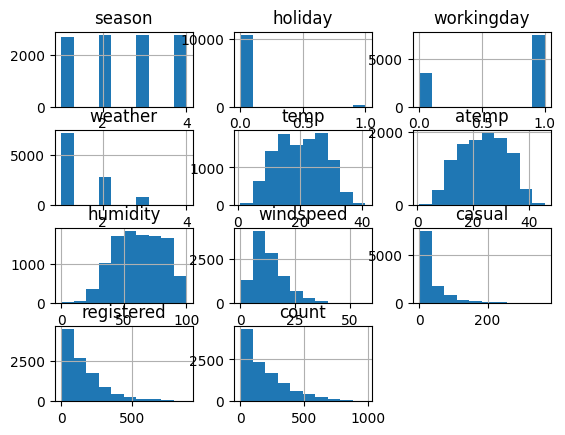

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,4


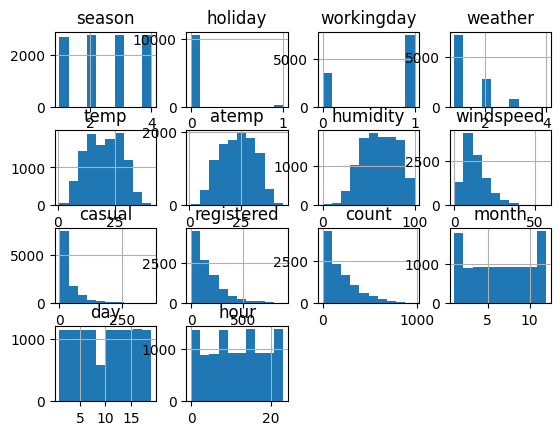

In [ ]:
# create a new feature
train['month'] = pd.to_datetime(train['datetime']).dt.month
train['day'] = pd.to_datetime(train['datetime']).dt.day
train['hour'] = pd.to_datetime(train['datetime']).dt.hour
test['month'] = pd.to_datetime(test['datetime']).dt.month
test['day'] = pd.to_datetime(test['datetime']).dt.day
test['hour'] = pd.to_datetime(test['datetime']).dt.hour

train = train.drop(columns=['datetime'])
test = test.drop(columns=['datetime'])
train.hist()
train.head()

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [ ]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [ ]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,4


array([[<Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'hour'}>]], dtype=object)

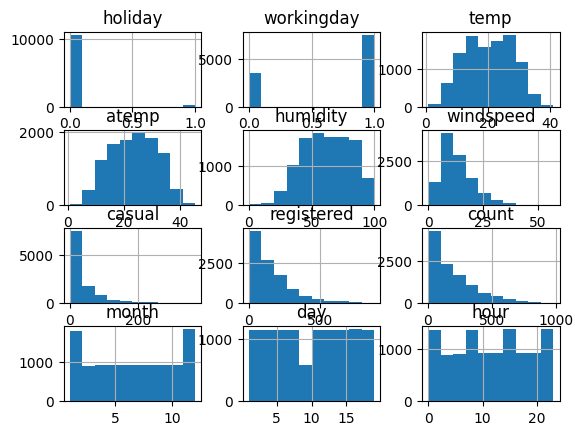

In [ ]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(
    label='count',
    eval_metric='root_mean_squared_error',
    learner_kwargs={'ignored_columns': ['casual', 'registered']}                        
    ).fit(
    train_data=train,
    time_limit=600,
    presets='best_quality'
    )

No path specified. Models will be saved in: "AutogluonModels/ag-20230527_023056/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230527_023056/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

In [ ]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -49.768955      58.888040  539.245980                0.000470           0.248702            3       True         16
1     ExtraTreesMSE_BAG_L2  -50.069928      57.846882  407.611280                0.484335           8.612660            2       True         14
2   RandomForestMSE_BAG_L2  -50.370594      57.875922  432.507702                0.513375          33.509082            2       True         12
3          CatBoost_BAG_L2  -50.447353      57.465937  451.459701                0.103390          52.461081            2       True         13
4          LightGBM_BAG_L2  -50.802604      57.467641  419.410285                0.105094          20.411664            2       True         11
5      WeightedEnsemble_L2  -51.371349      56.101407  356.779263         

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -123.93326033133259,
  'KNeighborsDist_BAG_L1': -119.3656013058328

In [ ]:
# Remember to set all negative values to zero
predictor_new_features = predictor_new_features.predict(test)
predictor_new_features.lt(0).value_counts()
predictor_new_features.iloc[predictor_new_features<0] = 0

In [ ]:
# Same submitting predictions
submission_new_features["count"] = predictor_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)



In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:01<00:00, 166kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2023-05-27 02:51:17  new features          complete  0.53929      0.53929       
submission.csv               2023-05-27 02:30:50  first raw submission  complete  1.80659      1.80659       
submission.csv               2023-05-26 18:01:01  first raw submission  complete  1.80470      1.80470       


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
hyperparameters = 'light'
hyperparameter_tune_kwargs = {
    'num_trials': 5,
    'searcher': 'random',
}

predictor_new_hpo = TabularPredictor(
    label='count',
    eval_metric='root_mean_squared_error',
    learner_kwargs={'ignored_columns': ['casual', 'registered']}                        
    ).fit(
    train_data=train,
    time_limit=1200,
    presets='best_quality',
    num_bag_folds=16, 
    num_bag_sets=1, 
    num_stack_levels=1,
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    )

No path specified. Models will be saved in: "AutogluonModels/ag-20230527_035205/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=16, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20230527_035205/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using 

In [ ]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  LightGBMLarge_BAG_L1 -50.846405       7.341833  153.845585                7.341833         153.845585            1       True          1
1   WeightedEnsemble_L2 -50.846405       7.343339  153.855830                0.001506           0.010245            2       True          2
2  LightGBMLarge_BAG_L2 -54.997741       7.758675  215.759198                0.416842          61.913613            2       True          3
3   WeightedEnsemble_L3 -54.997741       7.759153  215.762681                0.000479           0.003482            3       True          4
Number of models trained: 4
Types of models trained:
{'WeightedEnsembleModel', 'StackerEnsembleModel_LGB'}
Bagging used: True  (with 16 folds)
Multi-layer stack-ensembling used: True  (with 3 levels)
Feature Metadata (Processed):
(raw dty

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMLarge_BAG_L1': -50.846405277755984,
  'WeightedEnsemble_L2': -50.846405277755984,
  'LightGBMLarge_BAG_L2': -54.9977410901176,
  'WeightedEnsemble_L3': -54.9977410901176},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMLarge_BAG_L1': 'AutogluonModels/ag-20230527_035205/models/LightGBMLarge_BAG_L1/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20230527_035205/models/WeightedEnsemble_L2/',
  'LightGBMLarge_BAG_L2': 'AutogluonModels/ag-20230527_035205/models/LightGBMLarge_BAG_L2/',
  'WeightedEnsemble_L3': 'AutogluonModels/ag-20230527_035205/models/WeightedEnsemble_L3/'},
 'model_fit_times': {'LightGBMLarge_BAG_L1': 153.84558534622192,
  'WeightedEnsemble_L2': 0.010244607925415039,
  'LightGBMLarge_BAG_L2': 61.913612842

In [ ]:
# Remember to set all negative values to zero
predictor_new_hpo = predictor_new_hpo.predict(test)
predictor_new_hpo.lt(0).value_counts()

predictor_new_hpo.iloc[predictor_new_hpo<0] = 0

In [ ]:
# Same submitting predictions

submission_new_hpo["count"] = predictor_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 187k/187k [00:01<00:00, 107kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-05-27 03:59:58  new features with hyperparameters  complete  0.64194      0.64194       
submission_new_hpo.csv       2023-05-27 03:20:38  new features with hyperparameters  complete  0.63101      0.63101       
submission_new_hpo.csv       2023-05-27 03:04:24  new features with hyperparameters  complete  0.63101      0.63101       
submission_new_features.csv  2023-05-27 02:51:17  new features                       complete  0.53929      0.53929       


#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

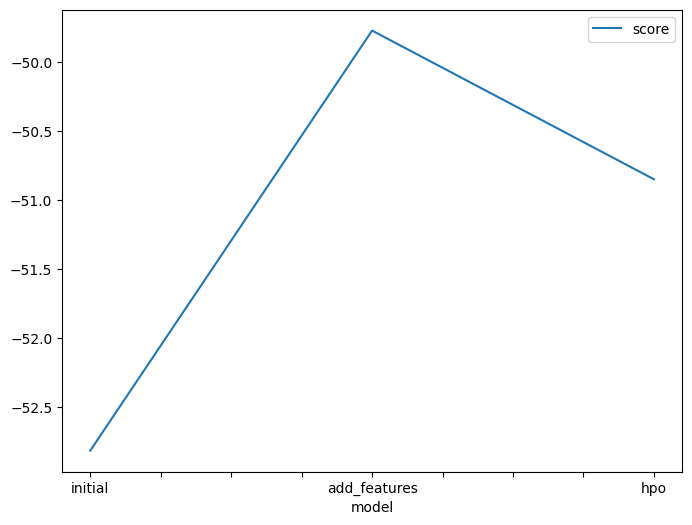

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-52.812486,
        -49.768955 ,
       -50.846405]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

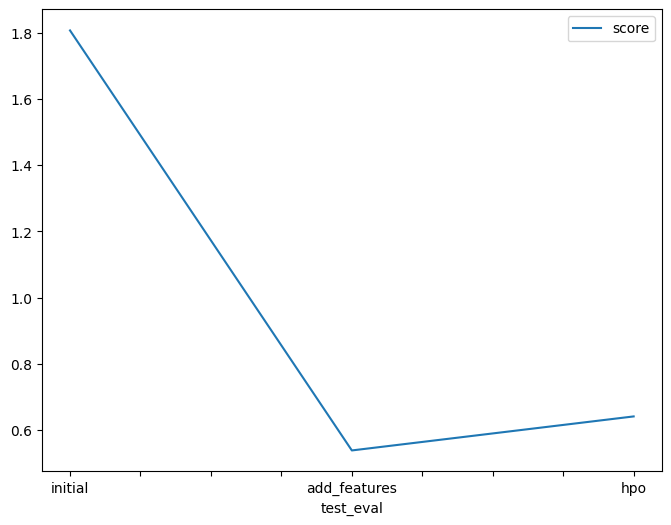

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80659, 0.53929,  0.64194]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "time_limit": [600, 600, 1200],
    "num_bag_folds": [8, 8, 16],
    "num_trials": [1, 1, 5],
    "score": [1.80659, 0.53929, 0.64194]
})

,model,time_limit,num_bag_folds,num_trials,score
0,initial,600,8,1,1.80659
1,add_features,600,8,1,0.53929
2,hpo,1200,16,5,0.64194
